In [1]:
!pip install spacy langdetect wordcloud --no-deps


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=7bec7c177f9bf4ea87987ed61475a484d072e9e8dab30b9c1560062422fbddf4
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re
import string
import wordcloud
from langdetect import detect
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import words

## EDA

### Read the Data

In [3]:
data_path = '/kaggle/input/suicide-watch/Suicide_Detection.csv'
df = pd.read_csv(data_path)

In [4]:
df.head(20)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide


### Data Summary

In [5]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
          Unnamed: 0
count  232074.000000
mean   174152.863518
std    100500.425362
min         2.000000
25%     87049.250000
50%    174358.500000
75%    261285.750000
max    348110.000000


### Check for missing value

In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Unnamed: 0    0
text          0
class         0
dtype: int64


### Count the class distribution

In [7]:
df['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

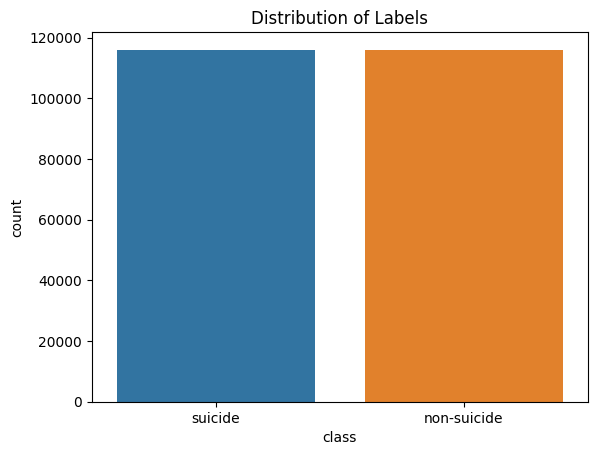

In [8]:
if 'class' in df.columns:
    sns.countplot(x='class', data=df)
    plt.title('Distribution of Labels')
    plt.show()

### Check for any duplicates rows

In [9]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


### Display word cloud

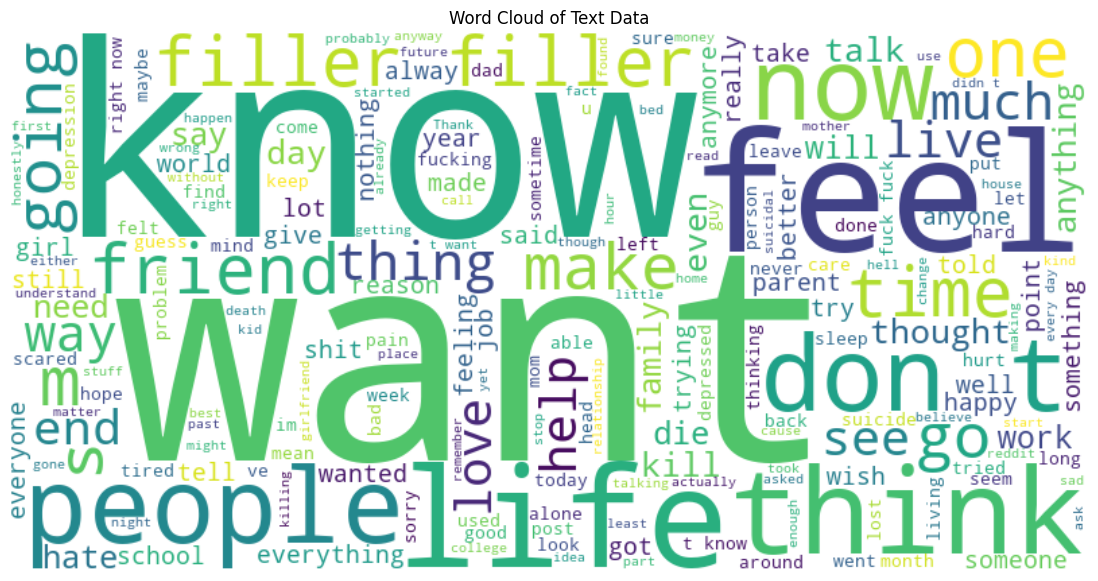

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(df['text'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()


## Data Preprocessing

### Lowercase all the text

In [11]:
df['text'] = df['text'].str.lower()

In [12]:
df.head(20)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently i left my ...,suicide
1,3,am i weird i don't get affected by compliments...,non-suicide
2,4,finally 2020 is almost over... so i can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"i’m so losthello, my name is adam (16) and i’v...",suicide
5,11,honetly idki dont know what im even doing here...,suicide
6,12,[trigger warning] excuse for self inflicted bu...,suicide
7,13,it ends tonight.i can’t do it anymore. \ni quit.,suicide
8,16,"everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,my life is over at 20 years oldhello all. i am...,suicide


### Replace "’" with "'"

In [13]:
df['text'] = df['text'].str.replace("’", "'")

In [14]:
df.head(20)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently i left my ...,suicide
1,3,am i weird i don't get affected by compliments...,non-suicide
2,4,finally 2020 is almost over... so i can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"i'm so losthello, my name is adam (16) and i'v...",suicide
5,11,honetly idki dont know what im even doing here...,suicide
6,12,[trigger warning] excuse for self inflicted bu...,suicide
7,13,it ends tonight.i can't do it anymore. \ni quit.,suicide
8,16,"everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,my life is over at 20 years oldhello all. i am...,suicide


### Replace the abbreviations

In [15]:
abb = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "dont": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "idk": "i do not know",
  "he'd've": "he would have",
  "he'll": "he will",  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "im": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is", "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have", "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",      "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have", "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have", "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}



In [16]:
abb_re = re.compile('(%s)' % '|'.join(abb.keys()))

def expandContractions(text, abb_re=abb_re):
    def replace(match):
        return abb[match.group(0)]
    return abb_re.sub(replace, text)

df['text'] = df['text'].apply(expandContractions)

In [17]:
df.head(20)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently i left my ...,suicide
1,3,am i weird i do not get affected by compli ame...,non-suicide
2,4,finally 2020 is almost over... so i can never ...,non-suicide
3,8,i need helpjust help me i am crying so hard,suicide
4,9,"i am so losthello, my name is adam (16) and i ...",suicide
5,11,honetly i do not knowi do not know what i am e...,suicide
6,12,[trigger warning] excuse for self inflicted bu...,suicide
7,13,it ends tonight.i cannot do it anymore. \ni quit.,suicide
8,16,"everyone wants to be ""edgy"" and it is making m...",non-suicide
9,18,my life is over at 20 years oldhello all. i am...,suicide


### Tokenization

In [18]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Function to tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

df['text'] = df['text'].apply(tokenize_text)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
df.head(20)

,Unnamed: 0,text,class
0,2,"[ex, wife, threatening, suiciderecently, i, le...",suicide
1,3,"[am, i, weird, i, do, not, get, affected, by, ...",non-suicide
2,4,"[finally, 2020, is, almost, over, ..., so, i, ...",non-suicide
3,8,"[i, need, helpjust, help, me, i, am, crying, s...",suicide
4,9,"[i, am, so, losthello, ,, my, name, is, adam, ...",suicide
5,11,"[honetly, i, do, not, knowi, do, not, know, wh...",suicide
6,12,"[[, trigger, warning, ], excuse, for, self, in...",suicide
7,13,"[it, ends, tonight.i, can, not, do, it, anymor...",suicide
8,16,"[everyone, wants, to, be, ``, edgy, '', and, i...",non-suicide
9,18,"[my, life, is, over, at, 20, years, oldhello, ...",suicide


### Word Segementation

In [20]:
!pip install wordninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=96ca169f104a778e42bea1fee75ca52891bb6ba955152737b6e2a8c1fd96ede2
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


In [21]:
import pandas as pd
import wordninja
import re

# Apply word segmentation tot he 'text' column in the DataFrame
df['text'] = df['text'].apply(lambda tokens: wordninja.split(" ".join(tokens)))

### Stopwords Removal

In [22]:
from nltk.corpus import stopwords

# Download the list of English stopwords
nltk.download('stopwords')

# Retrieve the English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the stopword removal function to the 'text' column
df['text'] = df['text'].apply(remove_stopwords)



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
df.head(10)

,Unnamed: 0,text,class
0,2,"[ex, wife, threatening, suicide, recently, lef...",suicide
1,3,"[weird, get, affected, comp, li, ment, coming,...",non-suicide
2,4,"[finally, 2020, almost, never, hear, 2020, bad...",non-suicide
3,8,"[need, help, help, crying, hard]",suicide
4,9,"[lost, hello, name, adam, 16, struggling, year...",suicide
5,11,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,12,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,13,"[ends, tonight, anymore, quit]",suicide
8,16,"[everyone, wants, edgy, ', ', making, self, co...",non-suicide
9,18,"[life, 20, years, old, hello, 20, year, old, b...",suicide


### Punctuation and Digit Removal

In [24]:
import string

# Function to remove punctuation and digits
def remove_punctuation(tokens):
    return [word for word in tokens if word not in string.punctuation and not word.isdigit()]

# Apply the function to remove punctuation and digits from the 'text' column
df['text'] = df['text'].apply(remove_punctuation)

# Display the first few rows of the 'text' column after removal
print(df['text'].head())


0    [ex, wife, threatening, suicide, recently, lef...
1    [weird, get, affected, comp, li, ment, coming,...
2    [finally, almost, never, hear, bad, year, ever...
3                     [need, help, help, crying, hard]
4    [lost, hello, name, adam, struggling, years, a...
Name: text, dtype: object


In [25]:
df.head(20)

,Unnamed: 0,text,class
0,2,"[ex, wife, threatening, suicide, recently, lef...",suicide
1,3,"[weird, get, affected, comp, li, ment, coming,...",non-suicide
2,4,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,8,"[need, help, help, crying, hard]",suicide
4,9,"[lost, hello, name, adam, struggling, years, a...",suicide
5,11,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,12,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,13,"[ends, tonight, anymore, quit]",suicide
8,16,"[everyone, wants, edgy, making, self, consciou...",non-suicide
9,18,"[life, years, old, hello, year, old, balding, ...",suicide


### Special Characters Removal

In [26]:
def remove_special_characters(tokens):
    # Remove special characters from each token using a regular expression
    return [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in tokens]

# Apply the function to remove special characters
df['text'] = df['text'].apply(remove_special_characters)

In [27]:
df.head(10)

,Unnamed: 0,text,class
0,2,"[ex, wife, threatening, suicide, recently, lef...",suicide
1,3,"[weird, get, affected, comp, li, ment, coming,...",non-suicide
2,4,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,8,"[need, help, help, crying, hard]",suicide
4,9,"[lost, hello, name, adam, struggling, years, a...",suicide
5,11,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,12,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,13,"[ends, tonight, anymore, quit]",suicide
8,16,"[everyone, wants, edgy, making, self, consciou...",non-suicide
9,18,"[life, years, old, hello, year, old, balding, ...",suicide


### Extra white spaces Removal

In [28]:
# Function to remove extra whitespaces
def remove_extra_whitespaces(tokens):
    # Strip leading and trailing whitespaces and filter out empty strings
    return [word.strip() for word in tokens if word.strip() != '']

df['text'] = df['text'].apply(remove_extra_whitespaces)


In [29]:
df.head(20)

,Unnamed: 0,text,class
0,2,"[ex, wife, threatening, suicide, recently, lef...",suicide
1,3,"[weird, get, affected, comp, li, ment, coming,...",non-suicide
2,4,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,8,"[need, help, help, crying, hard]",suicide
4,9,"[lost, hello, name, adam, struggling, years, a...",suicide
5,11,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,12,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,13,"[ends, tonight, anymore, quit]",suicide
8,16,"[everyone, wants, edgy, making, self, consciou...",non-suicide
9,18,"[life, years, old, hello, year, old, balding, ...",suicide


### Emoji, mail, and url removal

In [30]:
import re

# Function to remove URLs 
def remove_url(tokens):
    cleaned_tokens = [re.sub(r'http\S+', '', token) for token in tokens]
    return cleaned_tokens

# Function to remove email addresses 
def remove_mail(tokens):
    cleaned_tokens = [re.sub(r'\S+@\S+', '', token) for token in tokens]
    return cleaned_tokens

# Function to remove emojis 
def remove_emoji(tokens):
    cleaned_tokens = [re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FB00-\U0001FBFF\U0001FE00-\U0001FE0F\U0001F004]+', '', token) for token in tokens]
    return cleaned_tokens

df['text'] = df['text'].apply(remove_url)
df['text'] = df['text'].apply(remove_mail)
df['text'] = df['text'].apply(remove_emoji)

In [31]:
df.head(20)

,Unnamed: 0,text,class
0,2,"[ex, wife, threatening, suicide, recently, lef...",suicide
1,3,"[weird, get, affected, comp, li, ment, coming,...",non-suicide
2,4,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,8,"[need, help, help, crying, hard]",suicide
4,9,"[lost, hello, name, adam, struggling, years, a...",suicide
5,11,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,12,"[trigger, warning, excuse, self, inflicted, bu...",suicide
7,13,"[ends, tonight, anymore, quit]",suicide
8,16,"[everyone, wants, edgy, making, self, consciou...",non-suicide
9,18,"[life, years, old, hello, year, old, balding, ...",suicide


### Text Lemmatization

In [32]:
# Load the spaCy English model
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize_tokens(tokens):
    # Join the tokens back into a sentence
    text = ' '.join(tokens)
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize each token and return the lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

# Apply lemmatization t
df['text'] = df['text'].apply(lemmatize_tokens)

In [33]:
df.head(20)

,Unnamed: 0,text,class
0,2,"[ex, wife, threaten, suicide, recently, leave,...",suicide
1,3,"[weird, get, affect, comp, li, ment, come, som...",non-suicide
2,4,"[finally, almost, never, hear, bad, year, ever...",non-suicide
3,8,"[need, help, help, cry, hard]",suicide
4,9,"[lose, hello, name, adam, struggle, year, afra...",suicide
5,11,"[hone, ly, know, know, even, feel, like, nothi...",suicide
6,12,"[trigger, warn, excuse, self, inflict, burn, k...",suicide
7,13,"[end, tonight, anymore, quit]",suicide
8,16,"[everyone, want, edgy, make, self, conscious, ...",non-suicide
9,18,"[life, year, old, hello, year, old, bald, male...",suicide


### Remove non-English Words

we keep some of the words that maybe not include in english word of nltk that we think important for the model features

In [34]:
from nltk.corpus import words
import nltk

# Download the list of English words (if not already downloaded)
nltk.download('words')

# Load the set of English words
english_words = set(words.words())

# List of words to exclude from removal
words_to_exclude =  {
    'fuck','suicidal', 'depressed', 'anxiety', 'selfharm', 'overdose', 'hopeless',
    'cutting', 'lifeless', 'worthless', 'painful', 'enditall', 'sadness',
    'goodbye', 'helpme', 'hurtmyself', 'numb', 'alone', 'darkness', 'dying',
    'unloved', 'lost', 'killmyself', 'hanging', 'drugs', 'triggered',
    'relapse', 'cut', 'sh', 'kms', 'plshelp', 'wanttodie', 'tiredoflife'
}

# Function to remove non-English words from a list of tokens
def remove_non_english(tokens):
    english_tokens = [
        token if (token in english_words or token in words_to_exclude) else ''
        for token in tokens]
    return [token for token in english_tokens if token != '']

# Apply the function to the 'text' column in the DataFrame
df['text'] = df['text'].apply(remove_non_english)

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [35]:
df.head(20)
# Simpan dataset bersih ke file CSV
clean_dataset_path = "clean_dataset.csv"
df.to_csv(clean_dataset_path, index=False)
print(f"Clean dataset has been saved to {clean_dataset_path}.")


Clean dataset has been saved to clean_dataset.csv.
